In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import gc
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns



root = '/content/drive/MyDrive/INSTACART/data/'


In [3]:

# 🔹 Load Train and Test Data from Parquet Files
train_transformed = pd.read_parquet(root+"train_transformed.parquet")
test_transformed = pd.read_parquet(root+"test_transformed.parquet")


In [4]:
# split X_train and y_train and X_test and y_test
X_train_scaled = train_transformed.drop('reordered', axis=1)
y_train = train_transformed['reordered']
X_test_scaled = test_transformed.drop('reordered', axis=1)
y_test = test_transformed['reordered']

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),  # Reduce dropout to save memory
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,273 (24.50 KB)

 Trainable params: 6,273 (24.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 🔹 Compile Model with Additional Metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[AUC(name="auc"),'accuracy', Precision(), Recall() ],
              )


In [8]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)

class_weights = dict(enumerate(class_weights))  # Convert to dictionary


In [9]:
# add early stopping

# 🔹 Train Model
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=20, batch_size=32, verbose=1,class_weight=class_weights,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

                    )




Epoch 1/20
30289/30289 ━━━━━━━━━━━━━━━━━━━━ 163s 5ms/step - accuracy: 0.5992 - auc: 0.6003 - loss: 23.3290 - precision: 0.6763 - recall: 0.6334 - val_accuracy: 0.6419 - val_auc: 0.6842 - val_loss: 0.6385 - val_precision: 0.7382 - val_recall: 0.6226
Epoch 2/20
30289/30289 ━━━━━━━━━━━━━━━━━━━━ 154s 5ms/step - accuracy: 0.6482 - auc: 0.6653 - loss: 0.6463 - precision: 0.7069 - recall: 0.7040 - val_accuracy: 0.6709 - val_auc: 0.6723 - val_loss: 0.6325 - val_precision: 0.7036 - val_recall: 0.7779
Epoch 3/20
30289/30289 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step - accuracy: 0.6539 - auc: 0.6740 - loss: 0.6404 - precision: 0.7134 - recall: 0.7057 - val_accuracy: 0.6460 - val_auc: 0.7038 - val_loss: 0.6312 - val_precision: 0.7556 - val_recall: 0.6041
Epoch 4/20
30289/30289 ━━━━━━━━━━━━━━━━━━━━ 149s 5ms/step - accuracy: 0.6537 - auc: 0.6850 - loss: 0.6361 - precision: 0.7214 - recall: 0.6878 - val_accuracy: 0.6709 - val_auc: 0.6993 - val_loss: 0.6262 - val_precision: 0.7043 - val_recall: 0.7762
Epoch 5

In [10]:
# 🔹 Evaluate Model
loss, accuracy, precision, recall, auc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test AUC: {auc:.4f}")


12981/12981 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.6813 - auc: 0.7030 - loss: 0.6303 - precision: 0.7125 - recall: 0.7852
Test Accuracy: 0.7022
Test Precision: 0.6804
Test Recall: 0.7112
Test AUC: 0.7848


In [11]:

# 🔹 Compute F1-Score and Confusion Matrix
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")



12981/12981 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
F1-Score: 0.7462


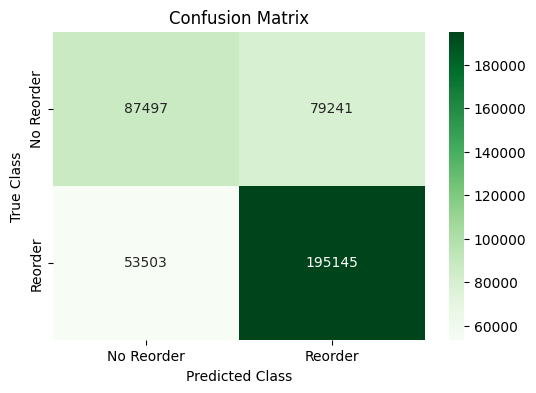

In [12]:
# 🔹 Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["No Reorder", "Reorder"], yticklabels=["No Reorder", "Reorder"])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()